In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [5]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [11]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<Axes: >

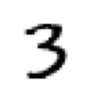

In [12]:
show_image(three_tensors[1])

In [13]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [14]:
len(stacked_threes.shape)

3

In [15]:
stacked_threes.ndim

3

<Axes: >

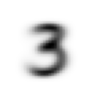

In [16]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

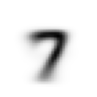

In [17]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<Axes: >

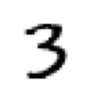

In [18]:
# arbitrary number
a_3 = stacked_threes[1]
show_image(a_3)

In [19]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [20]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [21]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255

valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [22]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [23]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [24]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1126, 0.1463, 0.1226,  ..., 0.1058, 0.1233, 0.1152]),
 torch.Size([1010]))

In [25]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [26]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [27]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [28]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [29]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [30]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [31]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [32]:
weights = init_params((28*28,1))

In [33]:
bias = init_params(1)

In [34]:
(train_x[0]*weights.T).sum() + bias

tensor([-6.2330], grad_fn=<AddBackward0>)

In [35]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -6.2330],
        [-10.6388],
        [-20.8865],
        ...,
        [-15.9176],
        [ -1.6866],
        [-11.3568]], grad_fn=<AddBackward0>)

In [36]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [37]:
corrects.float().mean().item()

0.5379961133003235

In [38]:
with torch.no_grad(): weights[0] *= 1.0001

In [39]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5379961133003235

In [40]:
help(torch.where)

Help on built-in function where in module torch:

where(...)
    where(condition, input, other, *, out=None) -> Tensor

    Return a tensor of elements selected from either :attr:`input` or :attr:`other`, depending on :attr:`condition`.

    The operation is defined as:

    .. math::
        \text{out}_i = \begin{cases}
            \text{input}_i & \text{if } \text{condition}_i \\
            \text{other}_i & \text{otherwise} \\
        \end{cases}

    .. note::
        The tensors :attr:`condition`, :attr:`input`, :attr:`other` must be :ref:`broadcastable <broadcasting-semantics>`.

    Arguments:
        condition (BoolTensor): When True (nonzero), yield input, otherwise yield other
        input (Tensor or Scalar): value (if :attr:`input` is a scalar) or values selected at indices
                              where :attr:`condition` is ``True``
        other (Tensor or Scalar): value (if :attr:`other` is a scalar) or values selected at indices
                              where 

In [41]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [42]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [43]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [44]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [45]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

In [46]:
def sigmoid(x): return 1/(1+torch.exp(-x))

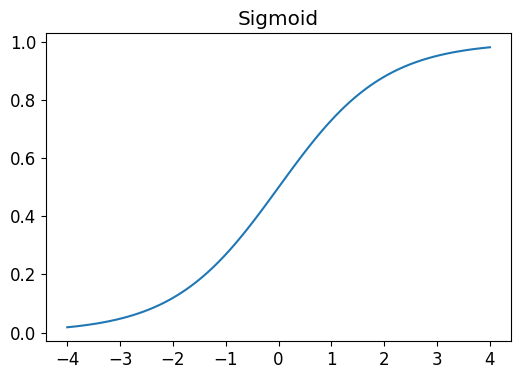

In [47]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [48]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [49]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [50]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [51]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

In [52]:
weights = init_params((28*28,1))
bias = init_params(1)

In [53]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [54]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [55]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [56]:
preds = linear1(batch)
preds

tensor([[11.6180],
        [ 9.0489],
        [-2.4524],
        [-2.5197]], grad_fn=<AddBackward0>)

In [57]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4616, grad_fn=<MeanBackward0>)

In [58]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0057), tensor([-0.0355]))

In [59]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [60]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0113), tensor([-0.0710]))

In [62]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [63]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [64]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [False]])

In [65]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [66]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [67]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [68]:
validate_epoch(linear1)

0.5485

In [69]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6293

In [70]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8129 0.913 0.9443 0.956 0.9623 0.9667 0.9692 0.9706 0.9721 0.9741 0.9745 0.975 0.976 0.9765 0.9765 0.977 0.9775 0.9775 0.9775 0.9775 

In [71]:
linear_model = nn.Linear(28*28,1)

In [72]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [84]:
class BasicOptim:
    def __init__(self,params,lr):
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [85]:
opt = BasicOptim(linear_model.parameters(), lr)

In [86]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [87]:
validate_epoch(linear_model)

0.3565

In [88]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [89]:
train_model(linear_model, 20)

0.4932 0.77 0.8559 0.9175 0.9355 0.9492 0.955 0.9633 0.9658 0.9682 0.9697 0.9726 0.9741 0.9746 0.976 0.976 0.9775 0.978 0.978 0.9785 

In [90]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8149 0.854 0.917 0.935 0.9497 0.9555 0.9629 0.9658 0.9682 0.9697 0.9716 0.9746 0.9751 0.976 0.977 0.978 0.978 0.9785 0.9785 

In [91]:
dls = DataLoaders(dl, valid_dl)

In [92]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [93]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636801,0.503659,0.495584,00:00
1,0.595294,0.167055,0.868008,00:00
2,0.216102,0.194360,0.820903,00:00
3,0.092935,0.109724,0.909715,00:00
4,0.047683,0.078979,0.932287,00:00
5,0.030144,0.062828,0.946025,00:00
6,0.023021,0.052928,0.955348,00:00
7,0.019919,0.046416,0.962218,00:00
8,0.018390,0.041868,0.965162,00:00
9,0.017501,0.038526,0.967615,00:00


In [97]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0)) # ReLU (Rectified Linear Unit, a function that's zero for negative values)
    res = res@w2 + b2
    return res

In [98]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

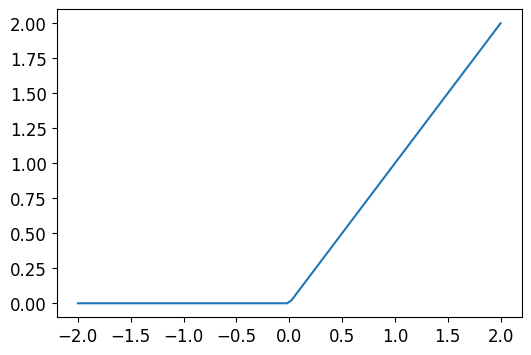

In [99]:
plot_function(F.relu)

In [100]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [101]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [102]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.317952,0.402303,0.505888,00:00
1,0.147431,0.224802,0.811580,00:00
2,0.081412,0.113134,0.918057,00:00
3,0.053371,0.076575,0.941609,00:00
4,0.040375,0.059810,0.957802,00:00
5,0.033737,0.050388,0.965162,00:00
6,0.029928,0.044459,0.967125,00:00
7,0.027458,0.040423,0.968106,00:00
8,0.025683,0.037500,0.969087,00:00
9,0.024311,0.035276,0.970069,00:00


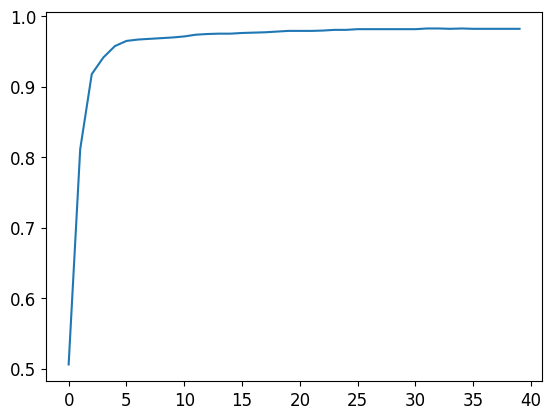

In [104]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [109]:
learn.recorder.values[-1][2]

0.98233562707901

In [110]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.086275,0.012340,0.996565,02:12
